# Pathogens of interest within the Sampler Comparison data

In [30]:
import pandas as pd
import seaborn as sns

## Starting with loading in the MARTi data

- Choosing the summed read counts
- Merging with metadata from contig stats and location, sampler
- convert the data types to numeric for later processing
- Add a column for relative abundance

In [17]:
#Loading in the data
raw_data = pd.read_csv('../samp_comp_0624_marti/samp_comp_summed_0624.csv') #summed data so I can collapse to different levels
# Melt the raw_data dataframe
raw_data_long = raw_data.melt(id_vars=['Taxon', 'NCBI_ID', 'Rank'], var_name='Sample_ID', value_name='Count')

metadata = pd.read_csv('../old_parameters_MARTI_samp_comp_read_data/Phyloseq_data/Sample_table.csv')

# Merge the melted raw_data with seq_info on 'Sample_ID'
merged_data = pd.merge(raw_data_long, metadata, on='Sample_ID', how='left')

merged_data = merged_data.replace(',','', regex=True)

merged_data.Location = merged_data.Location.astype('category')# Convert 'NumReads', 'N50Length', and 'Longest' from object to numeric
merged_data['NumReads'] = pd.to_numeric(merged_data['NumReads'], errors='coerce')
merged_data['N50Length'] = pd.to_numeric(merged_data['N50Length'], errors='coerce')
merged_data['Longest'] = pd.to_numeric(merged_data['Longest'], errors='coerce')

merged_data['Rel_Abundance'] = (merged_data['Count'] / merged_data['NumReads']) * 100

- Filter the data to Genus / Species level 
- filter the data to only contain the pathgoen genera of interest
- Also only include those with a rel abundance > 0.1%

In [49]:
genus_data = merged_data[(merged_data['Rank'] == 'genus') &
                          (merged_data['Count'] > 0)
                          ]

species_data = merged_data[(merged_data['Rank'] == 'species') &
                           (merged_data['Count'] > 0)
                          ]

In [54]:
pathogen_genera = [
    "Puccinia", "Blumeria", "Fusarium", "Zymoseptoria", 
    "Ustilago", "Magnaporthe", "Claviceps", "Pyrenophora",
    "Parastagonospora", "Phaeosphaeria"]

# Create a regex pattern to match any of the pathogen genera
pattern = '|'.join(pathogen_genera)

pathogen_genus_data = genus_data[
    (genus_data["Taxon"].isin(pathogen_genera)) &
    (genus_data["Rel_Abundance"] >= 0.1) #Filtering the data to only include >0.1 % relative abundance
    ]

pathogen_species_data = species_data[
    (species_data["Taxon"].str.contains(pattern)) &
    (species_data["Rel_Abundance"] >= 0.1) #Filtering the data to only include >0.1 % relative abundance
    ]

# pathogen_genus_data
pathogen_species_data["Taxon"].unique()

array(['Puccinia striiformis', 'Blumeria graminis', 'Ustilago hordei',
       'Puccinia triticina', 'Ustilago bromivora', 'Zymoseptoria tritici',
       'Fusarium avenaceum', 'Parastagonospora nodorum'], dtype=object)

### Plotting the marti pathogen data

- There are error bars because each sampler was tested 4 times in the different locations, for different flow rates and lengths of collection

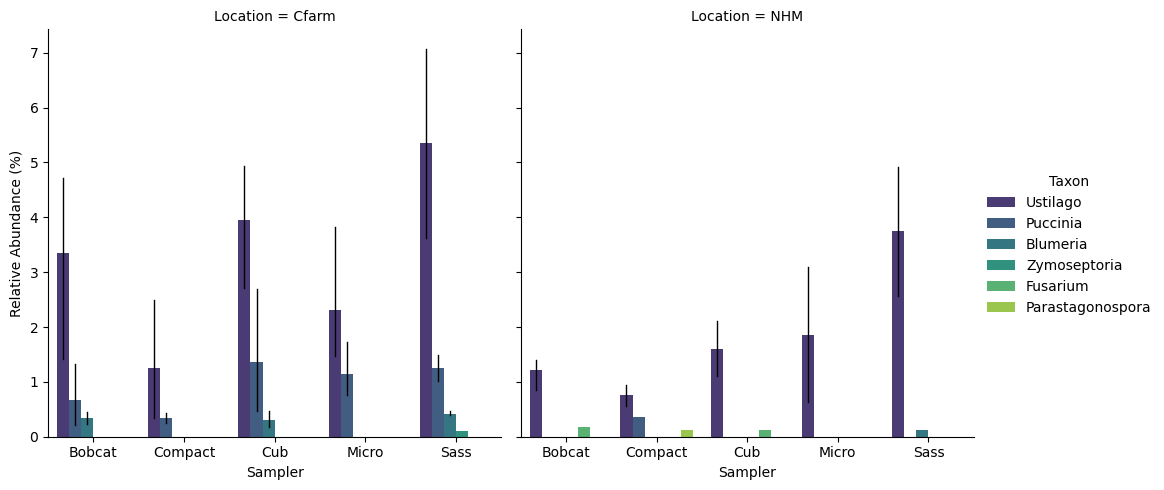

In [48]:
# Customize error bars
error_bar_properties = {
    'color': 'black',  # Darker color for error bars
    'linewidth': 1,    # Thinner error bars
}

g = sns.catplot(data=pathogen_genus_data,
                    x='Sampler',
                    y='Rel_Abundance',
                    kind='bar',
                    hue='Taxon',
                    palette= 'viridis',
                    col='Location',  # Facet by Location
                    err_kws=error_bar_properties  # Customize error bar
                    )

g.set_axis_labels("Sampler", "Relative Abundance (%)")

# Save the plot as an SVG file with an informative name
g.savefig("../Images/Relative_Pathgen_Abundance_by_Sampler_and_Location.svg", format='svg', dpi=300)